## Art Style Transfer

This notebook is an implementation of the algorithm described in "A Neural Algorithm of Artistic Style" (http://arxiv.org/abs/1508.06576) by Gatys, Ecker and Bethge. Additional details of their method are available at http://arxiv.org/abs/1505.07376 and https://bethgelab.org/deepneuralart/.

An image is generated which combines the content of a photograph with the "style" of a painting. This is accomplished by jointly minimizing the squared difference between feature activation maps of the photo and generated image, and the squared difference of feature correlation between painting and generated image. A total variation penalty is also applied to reduce high frequency noise. 

In [1]:
import sys
import lasagne
import numpy as np
import pickle
import skimage.transform
import scipy
import itertools
import os.path
import math
from functools import reduce

import theano
import theano.tensor as T

from lasagne.utils import floatX

import matplotlib.pyplot as plt
%matplotlib inline

Using cuDNN version 7102 on context None
Mapped name None to device cuda: GeForce GTX 960M (0000:01:00.0)


In [2]:
# VGG-19, 19-layer model from the paper:
# "Very Deep Convolutional Networks for Large-Scale Image Recognition"
# Original source: https://gist.github.com/ksimonyan/3785162f95cd2d5fee77
# License: non-commercial use only

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
#from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

IMAGE_W = 500

# Note: tweaked to use average pooling instead of maxpooling
def build_model():
    pool= 'average_exc_pad' #'average_exc_pad'  # average_exc_pad or max
    net = {}
    net['input'] = InputLayer((1, 3, IMAGE_W, IMAGE_W))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2, mode=pool)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2, mode=pool)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2, mode=pool)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2, mode=pool)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2, mode=pool)

    return net

In [3]:
# Download the normalized pretrained weights from:
# https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl
# (original source: https://bethgelab.org/deepneuralart/)

#!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl

In [4]:
# build VGG net and load weights

net = build_model()
if sys.version_info < (3,0,0):
    values = pickle.load(open('models/vgg19_normalized.pkl','rb'))['param values']
else:
    values = pickle.load(open('models/vgg19_normalized.pkl','rb'),encoding='latin-1')['param values']
lasagne.layers.set_all_param_values(net['pool5'], values)

In [5]:
MEAN_VALUES = np.array([103.939, 116.779, 123.68]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (IMAGE_W,((int) (w*IMAGE_W/h))), mode='constant', preserve_range=True)
    else:
        im = skimage.transform.resize(im, ((int) (h*IMAGE_W/w), IMAGE_W), mode='constant', preserve_range=True)

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_W//2:h//2+IMAGE_W//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    
    return rawim, floatX(im[np.newaxis])

(500, 500, 3)

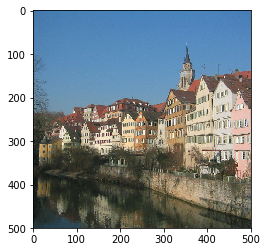

In [6]:
photo = plt.imread('pictures/neckarfront.jpg')
rawim, photo = prep_image(photo)
plt.imshow(rawim)
rawim.shape

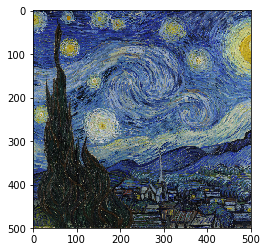

In [8]:
art = plt.imread('pictures/Starry_Night.jpg')
rawim, art = prep_image(art)
plt.imshow(rawim)

In [9]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g


def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    n=1.0
    for i in [0,1,2,3]:
        n*=p.shape[i]
    
    loss = 1./n * ((x - p)**2).sum()
    return loss


def style_loss_0(A, X, layer):
    """gramm loss"""
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(N**2 * M**2) * ((G - A)**2).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

In [10]:
def expected_value_1(a):
    return T.flatten(T.sum(T.sum(a,axis=-1)/a.shape[-1],axis=-1)/a.shape[-2])



def style_loss_1(A, X, layer):
    """expectat value loss"""
    a = A[layer]
    x = X[layer]
    
    A = expected_value_1(a)
    G = expected_value_1(x)
    
    
    loss = 1./(A.shape[0]) * ((G - A)**2).sum()
    return loss



In [11]:
def expected_value(a):
    return T.sum(T.sum(a,axis=-1)/a.shape[-1],axis=-1)/a.shape[-2]

def variance(a):
    return T.flatten(expected_value(a**2)-(expected_value(a)**2))/4.0
                 


def style_loss_2(A, X, layer):
    """variance loss"""
    a = A[layer]
    x = X[layer]
    
    A = variance(a)
    G = variance(x)
    
    
    loss = 1./(T.flatten(A).shape[0]) * (T.flatten(G - A)**2).sum()
    return loss


def style_loss_3(A,X,layer):
    """expected value and varriance loss"""
    return (style_loss_1(A,X,layer) + style_loss_2(A,X,layer)) /2.0

def style_loss_4(A,X,layer):
    """gram loss and varriance loss"""
    return (style_loss_0(A,X,layer) + style_loss_2(A,X,layer)) /2.0


In [12]:
layers = ['conv4_2', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
layers = {k: net[k] for k in layers}

In [13]:
# Precompute layer activations for photo and artwork
def precompute_activation(picture):
    input_im_theano = T.tensor4()
    outputs = lasagne.layers.get_output(layers.values(), input_im_theano)

    features = {k: theano.shared(output.eval({input_im_theano: picture}))
                      for k, output in zip(layers.keys(), outputs)}
    return features

#photo_features = precompute_activation(photo)
#art_features = precompute_activation(art)

In [14]:
# Get expressions for layer activations for generated image
generated_image = theano.shared(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

gen_features = lasagne.layers.get_output(layers.values(), generated_image)
gen_features = {k: v for k, v in zip(layers.keys(), gen_features)}

In [15]:
def loss(content_loss,style_loss,photo_features,art_features,selected_layers=None):

    # Define loss function
    losses = []

    # content loss
    losses.append(3.75e2* content_loss(photo_features, gen_features, 'conv4_2'))   #1.0e0 (experimental value)

    
    # style loss
    if selected_layers==None:
        selected_layers=[1,2,3,4,5]
        
    mul=2.5e5/float(len(selected_layers)) #5.0e3
    
    for i in selected_layers:
        if ((not (int(i)==i))or(i<1)or(i>5)): 
            raise Exeption("Layer not defined")
        losses.append(mul*style_loss(art_features, gen_features, 'conv'+str(i)+'_1'))

    # total variation penalty
    losses.append(0.1e-7 * total_variation_loss(generated_image)) #1.0e-10
    return sum(losses)
#total_loss = loss(content_loss,style_loss,photo_features,art_features)

In [16]:
def generate(total_loss,generated_image,show=True,maxfun=40*8,seed=False):
    
    grad = T.grad(total_loss, generated_image)

    
    # Theano functions to evaluate loss and gradient
    f_loss = theano.function([], total_loss)
    f_grad = theano.function([], grad)

    # Helper functions to interface with scipy.optimize
    def eval_loss(x0):
        x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
        generated_image.set_value(x0)
        return f_loss().astype('float64')

    def eval_grad(x0):
        x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
        generated_image.set_value(x0)
        return np.array(f_grad()).flatten().astype('float64')
       
    if seed:
        np.random.seed(42)
    # Initialize with a noise image
    generated_image.set_value(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))
    
    x0 = generated_image.get_value().astype('float64')
    
    
    ####Initialise with content image test
    #
    #generated_image.set_value(floatX(prep_image(plt.imread('pictures/neckarfront.jpg'))[1]))
    #
    #x0 = generated_image.get_value().astype('float64')
    ####
    
    #[103.939, 116.779, 123.68]
    
    #bounds:
    bounds    =   [(-103.939,255.0-103.939)]*(IMAGE_W*IMAGE_W)
    bounds.extend([(-116.779,255.0-116.779)]*(IMAGE_W*IMAGE_W))
    bounds.extend([(-123.68,255.0-123.68)]*(IMAGE_W*IMAGE_W))
    
    if show:
            
        global xs
        xs=[]
        xs.append(x0)
        def progress(xk):
            global xs
            xs.append(np.copy(xk).reshape((1, 3, IMAGE_W, IMAGE_W)))
    else:
        progress=None

    # Optimize, saving the result periodically
        
    
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(),bounds=bounds, fprime=eval_grad, callback=progress , maxfun=maxfun)
    x0 = generated_image.get_value().astype('float64')
    
    if show:
        xs.append(x0)
        return xs
    else:
        return x0

#xs = generate(eval_loss,eval_grad,generated_image)

In [17]:
def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [18]:
def compute(picture,artstyle,styledescriptor,progress=True,selected_layers=None,maxfun=40*8):
    """Wrapper function for artistic style transfair
    
        :param picture: content target
        :param artstyle: style target
        :param styledescriptor: styledescriptor to use
        :param progress: whether or not to store progres during optimisation
        :param selected_layers: 
        :param maxfun: maximal number of function evaluations during optimisation
        :type picture: path to picture 
        :type artstyle: path to artwork
        :type styledescriptor: styledescriptor function
        :type progress: bool 
        :type selected_layers: None for default architecture; subset of [1,2,3,4,5] for architecture composed of the layers convX_1
        :type maxfun: int 
        :return: generated picture not jet deprossesed
        :rtype: list if progress==True else single image
    """
    
    
    photo = prep_image(plt.imread(picture))[1]
    art = prep_image(plt.imread(artstyle))[1]
    photo_features = precompute_activation(photo)
    art_features = precompute_activation(art)
    total_loss = loss(content_loss,styledescriptor,photo_features,art_features,selected_layers=selected_layers)
    xs = generate(total_loss,generated_image,show=progress,maxfun=maxfun)

    #plt.figure(figsize=(8,8))
    #plt.imshow(deprocess(xs[-1]), interpolation='nearest')
    #return deprocess(xs[-1])
    return xs

In [19]:
def generate_all():
    pictures = ['neckarfront.jpg','lampe.jpg'] 
    art      = ['Starry_Night.jpg','Femme_nue_assise.jpg','Kandinsky.jpg','Seerosen.jpg','The_Scream.jpg']
    style_descriptor = [style_loss_0,style_loss_1,style_loss_2,style_loss_3,style_loss_4]
    directory = "output/default/"
    
    if not IMAGE_W == 500:
        print ("suboptimal resulution")
    
    def gen_name(p,a,sd):
        seperator = '-'
        return directory + sd.__name__[11:] + seperator + a[:-4] + seperator + p[:-4] + '.png'
    
    def to_generate():
        return filter(lambda x: not os.path.isfile(gen_name(*x)),itertools.product(pictures,art,style_descriptor))
    
    num=reduce(lambda count, x: count + 1, to_generate(), 0)
    cur=0
    
    for p,a,sd in to_generate():
        cur+=1
        fname = gen_name(p,a,sd)
        #str_num='('+str(cur).zfill((int)(np.log10(num)+1))+'/'+str(num)+') '
        str_num='('+str(cur)+'/'+str(num)+') '
        print (str_num+fname[len(directory):]+ ' generating...')
        plt.imsave(fname,deprocess(compute('pictures/'+p,'art/'+a,sd,False)))
        print (str_num+fname[len(directory):]+ ' finished')

#plt.imsave("output/test_X.png",deprocess(xs[-1]))

In [20]:
def style_to_style(picture,artstyle1,artstyle2,styledescriptor):
    xs=[]
    for a,b in [(1,0),(0.75,0.25),(0.5,0.5),(0.25,0.75),(0,1)]:
        def style_loss(styledescriptor):
            B = precompute_activation(prep_image(plt.imread(artstyle2))[1])
            return lambda A, X, layer: float (a) * styledescriptor(A,X,layer) + float(b) *styledescriptor(B,X,layer)        
        xs.append(deprocess(compute(picture,artstyle1,style_loss(styledescriptor),False)))
    return xs

In [21]:
def combine_pictures(xs,axis=1):
    return np.concatenate(xs,axis=axis)

In [22]:
def generate_style_to_style():
    picture = 'neckarfront.jpg'
    art      = ['Starry_Night.jpg','Kandinsky.jpg','Femme_nue_assise.jpg','The_Scream.jpg']
    style_descriptor = [style_loss_0,style_loss_1,style_loss_2,style_loss_3]
    
    def gen_name(a,sd):
        seperator = '-'
        return "output1/" + sd.__name__[11:] + seperator + a[0][:-4] + seperator + a[1][:-4] + '.png'
    
    artlist=[]
    
    for i in range(len(art)):
        for j in range(len(art)):
            if j < i:
                artlist.append((art[i],art[j]))
    
    def to_generate():
        return filter(lambda x: not os.path.isfile(gen_name(*x)),itertools.product(artlist,style_descriptor))
    
    num=reduce(lambda count, x: count + 1, to_generate(), 0)
    cur=0
    
    for a,sd in to_generate():
        cur+=1
        fname = gen_name(a,sd)
        #str_num='('+str(cur).zfill((int)(np.log10(num)+1))+'/'+str(num)+') '
        str_num='('+str(cur)+'/'+str(num)+') '
        print (str_num+fname[len("output1/"):]+ ' generating...')
        plt.imsave(fname,combine_pictures(style_to_style('pictures/'+picture,'art/'+a[0],'art/'+a[1],sd)))
        print (str_num+fname[len("output1/"):]+ ' finished')

#plt.imsave("output/test_X.png",deprocess(xs[-1]))

In [23]:
def gen_feature(a,b,c=0.0,l='conv4_1',i=0,gram=False):
    """generate texture that maximises ether the i-th entry of ether the gram matrix or total feature activation for the i-th feature
        :param a: weight of total vaariation loss
        :param b: weight of minimising all other
        :param c: weight of soft constrain towards "bright" pixels (linear, starting at 128 of 255 "pixel brightness")
        :param l: layer
        :param i: feature / entry
        :param gram: if True: maximise a gram matrix entry  else: the filter response for one filter 
        :type a,b,c: float
        :type l: l in ['conv4_2', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
        :type i: int
        :type gram: bool
        :return: generated texture not jet deprossesd
    
    """
        
    if not gram:
        mean_or_gram = T.sum(T.flatten(gen_features[l][0],ndim=2),axis=1)
    else:
        mean_or_gram = T.flatten(gram_matrix(gen_features[l]))
    
    soft_constrain_start    =   [128.0-103.939]*(IMAGE_W*IMAGE_W)
    soft_constrain_start.extend([128.0-116.779]*(IMAGE_W*IMAGE_W))
    soft_constrain_start.extend([128.0-123.68]*(IMAGE_W*IMAGE_W))
    
    
    
    soft_constrain_loss = ((T.maximum(T.flatten(generated_image),T.as_tensor_variable(soft_constrain_start)))).sum()

    lossfun_layer = mean_or_gram[i]
    #lossfun_other =( T.sum(T.sum(T.flatten(gen_features[l][0],ndim=2),axis=1)[0:i])+T.sum(T.sum(T.flatten(gen_features[l][0],ndim=2),axis=1)[i:]))/((a[l]).eval().shape[1]) 
    lossfun_other = 0.0
    if i >0:
        lossfun_other += T.sum(mean_or_gram[0:i])
    if i+1 < mean_or_gram.eval().shape[0]:
        lossfun_other += T.sum(mean_or_gram[i+1:])
    lossfun_other /= gen_features[l].shape[1]
       #1.0e6*(lossfun_other) +
    #(T.sum(T.flatten(gen_features['conv4_1'][0],ndim=2),axis=1)[0] -25.0)**2+
    return generate(  float(a) * total_variation_loss(generated_image) + float(b)*lossfun_other + 0.1e10/(lossfun_layer) + float(c) * soft_constrain_loss,generated_image,show=False)


In [24]:
def gen_feature_alt(a=1.0,b=10000,l='conv4_1',i=0):
    A=T.sum(T.flatten(gen_features[l][0],ndim=2),axis=1)
    X=theano.tensor.zeros_like(A)
    X=theano.tensor.set_subtensor(X[i],float(b))
    return generate(float(a) * total_variation_loss(generated_image) + ((A-X)**2).sum(),generated_image,show=False)


In [25]:
def gen_all_features(l='conv4_1',a=0.0,b=0.0,c=0.0,feature_generator=gen_feature,gram=False):
    print("modified for 16x16")
    xsi=[]
    
    if gram: 
        i_factor = 512 
    else: 
        i_factor = 16
              
    for i in range(16):
        xsj=[]
        for j in range(16):
                xsj.append(deprocess(feature_generator(a,b,c,l=l,i=i_factor*i+j,gram=gram)))
        xsi.append(combine_pictures(xsj))
        print("row: "+str(i))
    return combine_pictures(xsi,axis=0)

In [26]:
def gen_all_features_ab(l='conv4_1',feature_generator=gen_feature):
    xs=[0.0]
    c=1.0e-15
    for i in range(15):
        xs.append(c)
        c*=100.0
    xsi=[]
    for i in xs:
        xsj=[]
        for j in xs:
            xsj.append(deprocess(feature_generator(i,j,i=0)))
        xsi.append(combine_pictures(xsj))
        print("row" + str(i))
    return  combine_pictures(xsi,axis=0)

In [27]:
def create_plots():
    picture_list = ['Starry_Night.jpg','Femme_nue_assise.jpg','Kandinsky.jpg','Seerosen.jpg','The_Scream.jpg']
    data=[]
    for pic in picture_list:
        picture=prep_image(plt.imread("art/"+pic))[1]
        activation=precompute_activation(picture)
        data.append(T.flatten(activation['conv4_1'][0],ndim=2).eval())

    for a in range(16):
        for b in range(a+1,16):
        
            fig, axarr = plt.subplots(1,len(data), sharey=True, sharex=True,figsize=(len(picture_list)*3+1,3),dpi=300)

            for i in range(len(picture_list)):
    
                axarr[i].plot(data[i][a], data[i][b], '.')
                axarr[i].set(title=picture_list[i][:-4], xlabel='f_'+str(a), ylabel='f_'+str(b))

            plt.savefig("output/plots/f_"+str(a)+"xf_"+str(b)+".png",bbox_inches='tight')
            plt.close(fig)

#plt.xlabel('f_'+str(a+i))
#plt.ylabel('f_'+str(b+i))
#plt.plot(data[a+i], data[b+i],'.')
#plt.axis([min_x, max_x, min_y, max_y])

In [28]:
def gen_texture(artstyle,styledescriptor,progress=True,selected_layers=None,maxfun=40*8,seed=True):
    """Wrapper function for texture syntesys implemented as artistic style transfair without content target
    
        :param artstyle: style target
        :param styledescriptor: styledescriptor to use
        :param progress: whether or not to store progres during optimisation
        :param selected_layers: 
        :param maxfun: maximal number of function evaluations during optimisation 
        :param seed: whether or not to use a fixed random seed 
        :type artstyle: path to artwork
        :type styledescriptor: styledescriptor function
        :type progress: bool 
        :type selected_layers: None for default architecture; subset of [1,2,3,4,5] for architecture composed of the layers convX_1
        :type maxfun: int 
        :type seed: bool
        :return: generated texture not jet deprossesed
        :rtype: list if progress==True else single image
    """
    art = prep_image(plt.imread(artstyle))[1]
    art_features = precompute_activation(art)
    total_loss = loss(lambda *args,**kwargs:0.0,styledescriptor,None,art_features,selected_layers=selected_layers)
    xs = generate(total_loss,generated_image,show=progress,maxfun=maxfun,seed=seed)

    return xs

In [29]:
def x_entry_gram_style_loss(z):
    """gram loss with only (if z>=1 then z else z * amount of entrys ) random entrys of the gram matrix
    """
    def x_gram_loss(A, X, layer):      
        a = A[layer]
        x = X[layer]
        A = gram_matrix(a)
        G = gram_matrix(x)
    
        N = a.shape[1]
        M = a.shape[2] * a.shape[3]
        
        A=T.flatten(A)
        G=T.flatten(G)
        loss=0.0
        
        
        if z<1:
            Z=int(z*A.shape[0].eval())
        else:
            Z=z
        
            
        r=np.random.choice(range(A.shape[0].eval()),Z,False)
        loss=1./(float(Z) * M**2) * ((G[r]-A[r])**2).sum()
            
    
        #loss = 1./(z * M**2) * ((G - A)**2).sum()
        return loss
    return x_gram_loss

In [30]:
def gen_partial_gram_percent():
    path = "output/partial_gram/percent/"
    def fname(i):
        return path+str(i)+".png"
        
    for i in range(10,100,10):
        if not os.path.isfile(fname(i)):
            print("generating " + fname(i)[len(path):] +" ...")
            result=gen_texture("art/Starry_Night.jpg",x_entry_gram_style_loss((float(i))/100.0),progress=False)
            plt.imsave(fname(i),deprocess(result))
            print("finished " + fname(i)[len(path):])

In [31]:
def gen_partial_gram_presise():
    path = "output/partial_gram/1_div_by/"
    def fname(i):
        return path+str(i)+".png"
    
    for i in [ 2**(x+1) for x in range(int(math.log2(4096)))]:
        if not os.path.isfile(fname(i)):
            print("generating " + fname(i)[len(path):] +" ...")
            result=gen_texture("art/Starry_Night.jpg",x_entry_gram_style_loss((float(1.0))/float(i)),progress=False)
            plt.imsave(fname(i),deprocess(result))
            print("finished " + fname(i)[len(path):])

In [32]:
def gen_partial_gram_points():
    path = "output/partial_gram/points/"
    def fname(i):
        return path+str(i)+".png"
    
    for i in [ 2**x for x in range(int(math.log2(4096))+1)]:
        if not os.path.isfile(fname(i)):
            print("generating " + fname(i)[len(path):] +" ...")
            result=gen_texture("art/Starry_Night.jpg",x_entry_gram_style_loss(i),progress=False)
            plt.imsave(fname(i),deprocess(result))
            print("finished " + fname(i)[len(path):])

In [33]:
def combine_partial_gram():
    path = "output/partial_gram/percent/"
    def fname(i):
        return path+str(i)+".png"
    j=0
    xs=[]
    for i in range(10,100,10):
        xs.append(plt.imread(fname(i)))
    xs.reverse()
    xs.append(np.zeros_like(xs[0]))
    print (combine_pictures(axis=1,xs=xs[5:10]).shape)
    combined1 = combine_pictures(axis=0,xs=[combine_pictures(axis=1,xs=xs[0:5]),combine_pictures(axis=1,xs=xs[5:])])
    path = "output/partial_gram/1_div_by/"
    def fname(i):
        return path+str(i)+".png"
    xs=[]

    for i in [ 2**(x+1) for x in range(int(math.log2(4096)))]:
        xs.append(plt.imread(fname(i)))
    combined2 = combine_pictures(axis=0,xs=[combine_pictures(axis=1,xs=xs[0:6]),combine_pictures(axis=1,xs=xs[6:])])

    path = "output/partial_gram/points/"
    def fname(i):
        return path+str(i)+".png"
    xs=[]

    for i in [ 2**x for x in range(int(math.log2(4096))+1)]:
        xs.append(plt.imread(fname(i)))
    xs.reverse()
    xs.append(np.zeros_like(xs[0]))
    combined3 = combine_pictures(axis=0,xs=[combine_pictures(axis=1,xs=xs[0:7]),combine_pictures(axis=1,xs=xs[7:])])
    return [combined1,combined2,combined3]

In [34]:
def gen_all_partiall_gram():
    if IMAGE_W != 300:
        return -1
    gen_partial_gram_percent()
    gen_partial_gram_points()
    gen_partial_gram_presise()

In [36]:
a=compute("pictures/neckarfront.jpg","pictures/Starry_Night.jpg",style_loss_0,progress=False,selected_layers=None,maxfun=500)

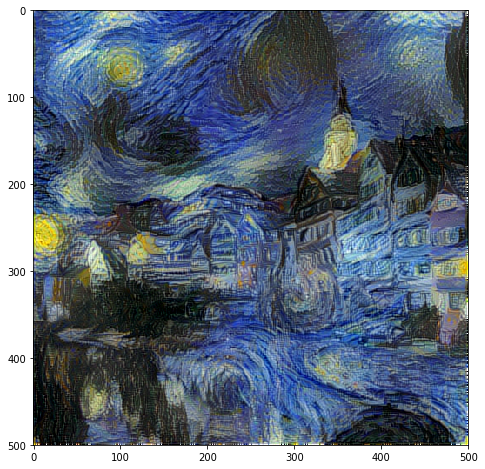

In [37]:
plt.figure(figsize=(8,8))
plt.imshow(deprocess(a))